# Neural Algorithmic Reasoning Project
This is a prototype. Using this to understand Neural Algorithmic Reasoning by imitating Belleman Ford


In [8]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

In [9]:
import random
import numpy as np
# This function is meant to generate graphs where there will be no isolated nodes
def gen_graph(n, p):
    while True:
        G = nx.fast_gnp_random_graph(n, p, directed=True)
        isolated_nodes = list(nx.isolates(G))
        print(isolated_nodes)
        if len(isolated_nodes) == 0:
            break

    for (u, v) in G.edges():
        G.edges[u, v]['weight'] = random.randint(1, 10)

    return G

def gen_graph(num_nodes, prob):
    G = nx.DiGraph()
    edges = np.random.rand(num_nodes, num_nodes) < prob
    
    for i in range(num_nodes):
        for j in range(num_nodes):
            if edges[i, j] and i != j:  # ensure no self-loops and edges follow the probability
                G.add_edge(i, j, weight=np.random.randint(1, 10))
    print("i got run")
    return G


# G = gen_graph(10, .5)
# plt.figure(figsize=(8, 6))
# pos = nx.spring_layout(G)
# nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=15)

# edge_labels = nx.get_edge_attributes(G, 'weight')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# plt.show()
# print(G.edges)
# This image looks bad but it shows that all edges have weights. 

### Dataset

The dataset must have contain not just the input and output node values, it must also contain intermediate steps because we will backpropogate in between steps in order to train the model to align with the algorithm at all steps. 

Therefore, there the dataset will contain 3 tensors.

We will be using an extension of Pytorch Geometric Datasets. Here is a quote from the ReadMe that says what is contained inside a PyG dataset:
---
data.x: Node feature matrix with shape [num_nodes, num_node_features]

data.edge_index: Graph connectivity in COO format with shape [2, num_edges] and type torch.long

data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]

data.y: Target to train against (may have arbitrary shape), e.g., node-level targets of shape [num_nodes, *] or graph-level targets of shape [1, *]

data.pos: Node position matrix with shape [num_nodes, num_dimensions]

---
<!-- 
We will not be needing data.pos, but we will need to find a way to add intermediate labels in order to train the whole algorithm trajectory. This will be done by extending the data object with a `data.hints field`. This will be a tensor of dimension `[num_nodes, label, num_time_steps]`. For graph algorithms, this will be the case, but for other algorithms the hints and other data parameters must be adjusted. 

But first, we must run the Belleman Ford Algorithm to generate a synthetic dataset. It should take the graph as an input, and return the hints for each time step and the final output. -->

The data will be represented as a single matrix of dimensions num nodes * num time steps,
the first time step will be the state of the graph after the bellman ford algorithm has been run once. 
The input will be the node edge weights. The outputs will be the last time step located in the same matrix. 

To ensure numerical stability, the initial graph state will have every value execpt the source be initialized to the max path length + 1, This will get appended to the beginning of the state matrix, and it will represent the input state of the graph. 

i got run
[(0, 4, {'weight': 9}), (4, 0, {'weight': 3}), (4, 2, {'weight': 9}), (1, 0, {'weight': 4}), (1, 2, {'weight': 9}), (1, 3, {'weight': 6}), (2, 1, {'weight': 7}), (3, 0, {'weight': 7}), (3, 2, {'weight': 3})]


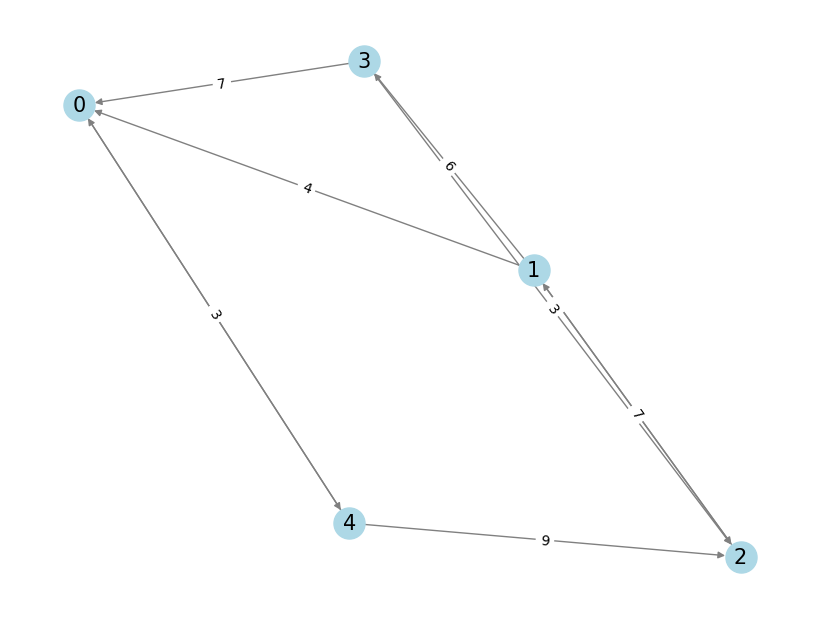

[(0, 4), (4, 0), (4, 2), (1, 0), (1, 2), (1, 3), (2, 1), (3, 0), (3, 2)]
ran
1 updated
edge: 0 4 weight: 9 distance sum: 0 100
1 updated
edge: 4 2 weight: 9 distance sum: 9 100
1 updated
edge: 2 1 weight: 7 distance sum: 18 100
ran
0 4 0 9 9
4 0 9 0 3
4 2 9 18 9
1 0 25 0 4
1 2 25 18 9
1 3 25 100 6
2 updated
edge: 1 3 weight: 6 distance sum: 25 100
2 1 18 25 7
3 0 31 0 7
3 2 31 18 3
ran
0 4 0 9 9
4 0 9 0 3
4 2 9 18 9
1 0 25 0 4
1 2 25 18 9
1 3 25 31 6
2 1 18 25 7
3 0 31 0 7
3 2 31 18 3
ran
0 4 0 9 9
4 0 9 0 3
4 2 9 18 9
1 0 25 0 4
1 2 25 18 9
1 3 25 31 6
2 1 18 25 7
3 0 31 0 7
3 2 31 18 3
tensor([[  0.,   0.,   0.,   0.,   0.],
        [100.,  25.,  25.,  25.,  25.],
        [100.,  18.,  18.,  18.,  18.],
        [100., 100.,  31.,  31.,  31.],
        [100.,   9.,   9.,   9.,   9.]])


In [19]:
# Run the Belleman Ford Algorithm, return a numpy array containing the output of the algorithm at each time step for each node.

import numpy as np
import math

# Note: In this case, we will assume node 0 is the source node.
def bellman_ford(G):
    num_nodes = len(G.nodes())
    
    # Initialize distances
    distances = [ 100 ] * len(G.nodes)
    distances[0] = 0
    
    # Create a list to store all states (including initial and final)
    states = [list(distances)]
    
    # Relax edges |V| - 1 times
    count = 0
    for _ in range(num_nodes - 1): 
        print("ran")
        count += 1
        
        for u, v, weight in G.edges(data='weight', default=1):
            if count >= 2:
                print(u, v, distances[u], distances[v], weight)
            if distances[u] + weight < distances[v]:
                print(count, "updated")
                print("edge:", u, v, "weight:", weight, "distance sum:", distances[u], distances[v])
                distances[v] = distances[u] + weight
                

        states.append(list(distances))    
    
    final = torch.from_numpy(np.stack(states, axis=1))

    return final.float()
       
     
gr = gen_graph(5, .5)

print(gr.edges(data=True))

# Create a graph

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(gr)
nx.draw(gr, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=15)

edge_labels = nx.get_edge_attributes(gr, 'weight')
nx.draw_networkx_edge_labels(gr, pos, edge_labels=edge_labels)

plt.show()
print(gr.edges)

# Run Bellman-Ford algorithm

result = bellman_ford(gr)
print(result)


Now that we have a graph, and its states at each time step, we will make the dataset.

### Generate Dataset

A dataset in pytorch geometric is a collection of `Data` objects. 

In [11]:
from torch.utils.data import Dataset
from networkx import to_edgelist
from torch_geometric.data import Data

# TODO: This should be made such that num graphs, num nodes, and edge_prob are random, so that the model won't learn
# to rely on a certain number of nodes or edge frequency. 
class NAR_dataset(Dataset):
    def __init__(self, num_graphs, num_nodes, edge_prob):
        self.data_list = []
        self.num_graphs = num_graphs
        self.num_nodes = num_nodes
        self.edge_prob = edge_prob
        
        for _ in range(self.num_graphs):
            self.data_list.append(self._generate_data())
            
        
    def _generate_data(self):
        # The first thing it will do is generate a networkx graph.
        g = gen_graph(self.num_nodes, self.edge_prob)
        
        # Then Apply the Bellman Ford algo
        b_ford = belleman_ford(g)
        
        edges = to_edgelist(g)
        
        src = []
        dst = []
        edge_weights = []
        for u, v, w in g.edges(data=True):
            src.append(u)
            dst.append(v)
            edge_weights.append(w['weight'])
        
        src = torch.tensor(src)
        dst = torch.tensor(dst)
        edge_index = torch.stack([src, dst], dim=0)
        
        edge_weights = torch.tensor(edge_weights)
        
        # X is empty in case we want to fill it in later
        data = Data(
            edge_index=edge_index,
            edge_attr=edge_weights,
            y=b_ford,
            x=torch.zeros(len(g.nodes))
        )
        return data
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        return self.data_list[idx]
    
    def __str__(self):
        return str([i for i in self.data_list])

# dataset = NAR_dataset(5, 10, .5)
# from torch_geometric.data import DataLoader 
# test_dataloader = DataLoader(dataset, batch_size=1)

# for i, data in enumerate(test_dataloader):
#     print(data.edge_index)
#     print(data.y)
#     break
        
        

## The model
Now that we have the dataset, we will build the model. The model is consisted of:

1. Encoder: Simple MLP that encodes scalar inputs into higher dimensional latent space.
2. Processor: Message-Passing Graph Neural Network that performs message passing. 
3. Decoder: MLP that decodes latent representation back into scalars. 

This runs off the Encode-Process-Decode framework. This model must be trained along the entire trajectory of the algorithm. For this reason, it is run multiple times, one for each state of the graph at that time step. Step wise supervision is performed. 

In the paper "Neural Execution of graph algorithms, they use another component to determine whether or not the algorithm should be run again. This gives the model non-deterministic runtime length. 

I will be basing my Encode Process Decode scheme on the CLRS paper and "A generalist Neural Algorithmic Learner".

The steps go as follows:

1. The model is initialized with the inputs getting passed into the encoder. The encoder will embed the inputs into a latent space and they will be used as input for the single GNN layer (in our case GCN, but GAT and other can be used)
2. The GNN will perform message passing. 
3. The outputs from the GNN will be used as input into the decoder. The decoder will use that to predict the hints for the next step. 
4. Based on the predicted hints, loss will be calculated and backpropagation will happen (In this case, MSE).
5. The real hints will get passed into the encoder again. What is encoded will be added to the previous latent representation. 
6. The cycle repeats until the algorithm has finished. 

In this model, the amount of times it will be run will be fixed. In future versions, I will make a seperate model that can decide if this model should continue or not.  

In [12]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, Linear
class NAR_model(torch.nn.Module):
    def __init__(self, hidden_dim):
        super(NAR_model, self).__init__()
        
        self.enc = Linear(1, hidden_dim)
        self.proc = GCNConv(hidden_dim, hidden_dim, aggr="max") # Note in case its important later, this normalizes inputs. 
        self.dec = Linear(hidden_dim, 1)
        
        # This will give a probability whether or not to continue. 
        # self.next = Linear(128, 1) 

    
    def forward(self, inputs, edge_index, prev_embeddings=None):
        print(inputs.shape)
        x = self.enc(inputs)
        # print(edge_index)
        if prev_embeddings is not None:
            x = x + prev_embeddings
        x = F.relu(x)
        
        print(x.shape)
        x = self.proc(x, edge_index)
        x = F.relu(x)
          
        y = self.dec(x)
    
        return y, x 
    
        

### Training the model

This will be trained with MSE. Note that the test dataset is much larger than the train dataset. This is to test the model's out of distribution performance. 

In [13]:
# Generate dataset with previously made function.
from torch_geometric.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = NAR_dataset(128, 16, 0.5)
test_dataset = NAR_dataset(32, 64, 0.5)

model = NAR_model(128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

# def train(time_step, prev_pred):
#     model.train()
#     optimizer.zero_grad()
#     out = model(data.x, data.edge_index)
#     loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
#     loss.backward()
#     optimizer.step()
#     return float(loss)

def train(data):
    model.train()
    optimizer.zero_grad()
    
    total_loss = 0
    prev_emb = None
    for i in range(8):
        pred, prev_emb = model(data.y[:, i].view(-1,1), data.edge_index, prev_embeddings=prev_emb)
        loss = F.mse_loss(pred, data.y[i+1].view(-1,1))
        loss.backward()
        optimizer.step()
        total_loss += float(loss)
    
    return total_loss
        
        


dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

for epoch in range(50):
    # For this simplified example, we will be running the model 8 times per cycle.
    for step, data in enumerate(dataloader):
        prev_pred = None
        data.to(device)
        loss = train(data)
        print(step, loss)
        
            
        
       

    

i got run


NameError: name 'belleman_ford' is not defined